In [2]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import matplotlib.pyplot as plt
from rdflib import ConjunctiveGraph
%matplotlib inline  

In [3]:
prefix = "PREFIX : <http://data.krw.d2s.labs.vu.nl/group20/vocab/>"
TUTORIAL_REPOSITORY = "http://stardog.krw.d2s.labs.vu.nl/group20"
endpoint = TUTORIAL_REPOSITORY + "/query"

In [4]:
def clearStardog():
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/clear"
    response = requests.post(post_url, headers={'Accept': 'text/plain'})
    
    print "Sent clear request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

def upload_file_to_stardog(filename, mimetype='application/trig'):
    
    with open(filename,'r') as f:
        data = f.read()
        
    upload_to_stardog(data, mimetype=mimetype)
    
    return
    

def upload_to_stardog(data, mimetype='application/trig'):
    transaction_begin_url = TUTORIAL_REPOSITORY + "/transaction/begin"
    
    # Start the transaction, and get a transaction_id
    response = requests.post(transaction_begin_url, headers={'Accept': 'text/plain'})
    transaction_id = response.content

    print "Transaction id: {}".format(transaction_id)
    
    # POST the data to the transaction
    post_url = TUTORIAL_REPOSITORY + "/" + transaction_id + "/add"
    response = requests.post(post_url, data=data, headers={'Accept': 'text/plain', 'Content-type': mimetype}, stream=True)

    print "Sent add request: {}".format(response.status_code)
    
    # Close the transaction
    transaction_close_url = TUTORIAL_REPOSITORY + "/transaction/commit/" + transaction_id
    response = requests.post(transaction_close_url)

    print "Closing transaction: {}".format(response.status_code)
    
    return

    
def getClasses(reasoning='true', max=None):
    
    if max is None :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class }"""
    else :
        query = prefix + """SELECT ?c WHERE {?c a owl:Class } LIMIT """ + str(max)
    
    return [r['c']['value'] for r in runQuery(query, reasoning)]
    

def getInstances(className, reasoning='true'):
    query = prefix + """
    SELECT ?i WHERE {{?i a {} . }}
    """.format(className)
    
    return [r['i']['value'] for r in runQuery(query, reasoning)]

def countUsage(reasoning='true', max=None):
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'resource' in r:
            index[unicode(r['resource']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def countClassUsage(reasoning='true', max=None):
    query = """
        SELECT ?class (COUNT(?resource) as ?count) WHERE {
            ?resource a ?class . 
        } GROUP BY ?class ORDER BY DESC(?count)
    """
    
    results = runQuery(query, reasoning)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        if 'class' in r:
            index[unicode(r['class']['value'])] = int(r['count']['value'])
        
        count += 1
    
    return index


def runQuery(query, reasoning='true'):
    sparql = SPARQLWrapper(endpoint)

    sparql.setQuery(query)

    sparql.setReturnFormat(JSON)
    sparql.addParameter('Accept','application/sparql-results+json')

    sparql.addParameter('reasoning',reasoning)

    response = sparql.query().convert()

    return response['results']['bindings']

In [5]:
upload_file_to_stardog('o1.trig')
upload_file_to_stardog('o2.trig')
upload_file_to_stardog('d1.trig')
upload_file_to_stardog('d2.trig')

Transaction id: 759e9788-5e12-4bf2-a6af-425240e1ed34
Sent add request: 200
Closing transaction: 200
Transaction id: 52fddf61-76a3-4e66-9dd0-9dd75960c0ea
Sent add request: 200
Closing transaction: 200
Transaction id: cc0b7361-65e8-4e5c-b609-962885c75c6d
Sent add request: 200
Closing transaction: 200
Transaction id: e8cffd77-cfe5-49cd-93e7-575202ae8099
Sent add request: 200
Closing transaction: 200


In [10]:
getClasses(max=1000, reasoning='true')

[u'http://data.krw.d2s.labs.vu.nl/group20/vocab/D',
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/G',
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/F',
 u'http://www.w3.org/2002/07/owl#Thing',
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/A',
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/C',
 u'http://www.w3.org/2002/07/owl#Nothing',
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/B']

In [13]:
getInstances('<http://www.w3.org/2002/07/owl#Nothing>', reasoning='true')

[]

In [50]:
## Load a graph
g = ConjunctiveGraph()

#g += g.parse('o1.trig', format='trig')
#g += g.parse('o2.trig', format='trig')
#g += g.parse('d1.trig', format='trig')
#g += g.parse('d2.trig', format='trig')


g += g.parse('group6.trig', format='trig')

In [30]:
def countUsageLocal(rdfgraph, max=None):
    query = """
        SELECT ?resource (COUNT(?resource) as ?count) WHERE {
            { ?resource ?p1 ?o1 . }
            UNION
            { ?s1 ?resource ?o2 . }
            UNION
            { ?s2 ?p2 ?resource . }
        } GROUP BY ?resource ORDER BY ?resource
    """
    
    results = g.query(query)
    
    index = {}
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
            
        index[unicode(r['resource'])] = int(r['count'])
        
        count += 1
    
    return index
    
    

In [51]:
index = countUsageLocal(g)

In [52]:
index

{u'https://media.iamsterdam.com/ndtrc/Images/20150122/2603846f-5db0-4481-bfe8-b39169c22c5f.jpg': 1,
 u'Museumlaan 18': 2,
 u'Date multiple: a partire da Gi 4 febbraio 2016 Da Gi 19 maggio 2016.': 1,
 u'Lu -Do : 11:00 - 17:00 Hora,\nCerrado Mi 27 Abril 2016\nCerrado Lu 3 Octubre 2016\nCerrado Ma 4 Octubre 2016\nCerrado Mi 12 Octubre 2016.': 1,
 u'bedrijfsverzamelgebouw': 1,
 u'Di 17 Avril 2016 20:15 heure.': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Azartplein_zijweg_45-47': 4,
 u'52.34539': 1,
 u'tov 1980': 1,
 u'OOSTZANERDIJK 151': 3,
 u'(4 p.p. vanaf Willem Sandbergplein)': 1,
 u'52.34532': 1,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Ingenhouszhof_47': 4,
 u'52.29503': 2,
 u'http://data.krw.d2s.labs.vu.nl/group6/findaslot/resource/Jan_Pieter_Heijestraat_62_-_74': 4,
 u'Theater Bellevue Amsterdam | 23 en 24 april 2016. Deze voorstelling maakt deel uit van het Pop Arts Festival. Dik en Adam, twee traditionele clowns, zijn op miraculeuze wijze in 

In [33]:
index_remote = countUsage(reasoning='false')

In [34]:
index_remote

{u'http://data.krw.d2s.labs.vu.nl/group20/vocab/A': 5,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/B': 7,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/C': 6,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/D': 5,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/F': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/G': 1,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i1': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i2': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i3': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i4': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/j1': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/j2': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/j3': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/j4': 2,
 u'http://data.krw.d2s.labs.vu.nl/group20/vocab/j5': 2,
 u'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': 23,
 u'http://www.w3.org/2000/01/rdf-schema#subClassOf': 6,
 u'http://www.w3.org/2002/07/owl#Class': 5,
 u'http:/

In [55]:
index_classes = countClassUsage(reasoning='true')

In [56]:
index_classes

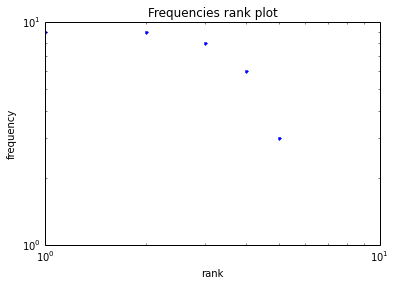

In [57]:
frequencies_by_value = sorted(index.values(), reverse=True)

plt.loglog(frequencies_by_value,'b-',linestyle='None', marker='.')
plt.title("Frequencies rank plot")
plt.ylabel("frequency")
plt.xlabel("rank")

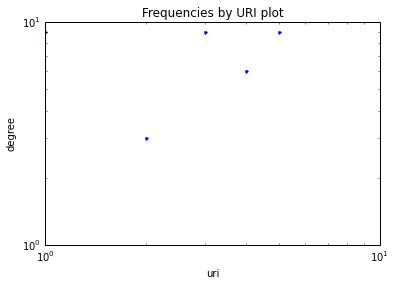

In [58]:
frequencies_by_URI = index.values()

plt.loglog(frequencies_by_URI,'b-',linestyle='None', marker='.')
plt.title("Frequencies by URI plot")
plt.ylabel("degree")
plt.xlabel("uri")

In [35]:
def buildNetwork(rdfgraph, query = """SELECT * WHERE {?source ?edge ?target.}""", max=None):
    ## Query is assumed to have a source, target and edge
    
    results = g.query(query)
    
    G = nx.DiGraph()
    
    count = 0
    for r in results:
        if not max is None and count > max:
            break
        
        G.add_edge(r['source'], r['target'], {'type': r['edge']})
        
        count += 1
        
    return G


In [59]:
G = buildNetwork(g, max=10000)

In [61]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

# And see what it looks like...
degree_sequence

[388,
 381,
 341,
 305,
 273,
 245,
 104,
 101,
 68,
 53,
 52,
 50,
 50,
 44,
 41,
 38,
 37,
 34,
 34,
 32,
 28,
 27,
 26,
 26,
 24,
 23,
 23,
 23,
 23,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 1

KeyboardInterrupt: 

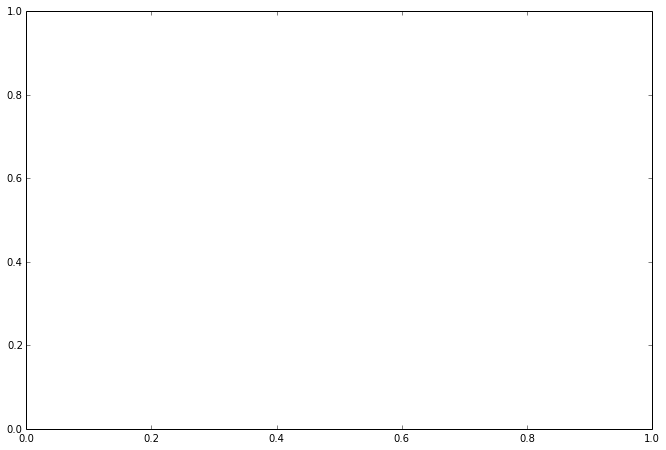

In [62]:
# draw graph in inset
plt.axes([1.45,1.45,1.45,1.45])
#Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G,pos,node_size=50)
nx.draw_networkx_edges(G,pos,alpha=0.4)

# plt.savefig("graph.png")
plt.show()

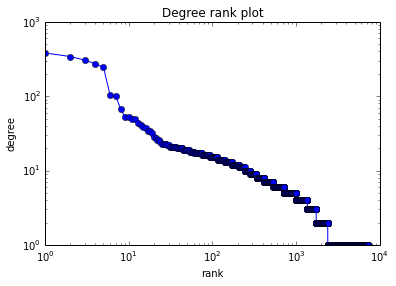

In [65]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

In [49]:
nx.pagerank(G)

{rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/A'): 0.06337752861410018,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/B'): 0.09031299620280547,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/C'): 0.10990573508355334,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/D'): 0.07712675888421919,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/F'): 0.02785814733055799,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/G'): 0.07456797757401873,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i1'): 0.02785814733055799,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i2'): 0.02785814733055799,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i3'): 0.02785814733055799,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab/i4'): 0.02785814733055799,
 rdflib.term.URIRef(u'http://data.krw.d2s.labs.vu.nl/group20/vocab